In [134]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import load_model
import keras.optimizers
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import warnings


warnings.filterwarnings("ignore", category=FutureWarning)

In [135]:
IMAGE_SIZE = [50,50]
eps = 20
lr = 0.001
bs = 20

In [136]:
# Give dataset path
train_path = "Task2_dataset//training/"
test_path = "Task2_dataset//testing/"

In [137]:
# from PIL import Image
# import os
# from IPython.display import display
# from IPython.display import Image as _Imgdis


# # creating a object


# folder = train_path + "/benign"


# onlybenignfiles = [

#     f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))

# ]
# print("Working with {0} images".format(len(onlybenignfiles)))
# print("Image examples: ")


# for i in range(10):
#     print(onlybenignfiles[i])
#     display(_Imgdis(filename=folder + "/" + onlybenignfiles[i], width=50, height=50))

In [138]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights="imagenet", include_top=False)

In [139]:
vgg.input

<KerasTensor: shape=(None, 50, 50, 3) dtype=float32 (created by layer 'input_8')>

In [140]:
for layer in vgg.layers:
    layer.trainable = False

In [141]:
folders = glob("Task2_dataset//training/*")
print(len(folders))

5


In [142]:
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation="softmax")(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

Total params: 14717253 (56.14 MB)
Trainable params: 2565 (10.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [143]:
from keras import optimizers

optimizer = optimizers.Adam(lr)
# optimizer.learning_rate.assign(0.0001)
print(optimizer.learning_rate)

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"],
)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>


In [144]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


#train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [145]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


#test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [146]:
train_set = train_datagen.flow_from_directory(
    train_path, target_size=(IMAGE_SIZE), batch_size=bs, class_mode="categorical"
)

Found 2344 images belonging to 5 classes.


In [147]:
test_set = test_datagen.flow_from_directory(
    test_path, target_size=(IMAGE_SIZE), batch_size=bs, class_mode="categorical"
)

Found 10 images belonging to 5 classes.


In [148]:
from keras import backend as K
class printlearningrate(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        lr = K.eval(optimizer.lr)
        Epoch_count = epoch + 1
        print('\n', "Epoch:", Epoch_count, ', LR: {:.2f}'.format(lr))

printlr = printlearningrate() 
def scheduler(epoch):
  optimizer = model.optimizer
  return K.eval(optimizer.lr)

updatelr = keras.callbacks.LearningRateScheduler(scheduler)

In [149]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint

metric = "accuracy"
checkpoint = ModelCheckpoint(
    filepath="vgg16model.h5", monitor=metric, verbose=2, save_best_only=True, mode="max"
)
callbacks = [checkpoint]

start = datetime.now()

model_history = model.fit_generator(
    train_set,
    validation_data=test_set,
    epochs=eps,
    steps_per_epoch=5,
    validation_steps=5,
    callbacks=callbacks,
    verbose=2,
)
duration = datetime.now() - start
print("Training completed in time: ", duration)

/tmp/ipykernel_10489/1546718044.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


Epoch 1/20

Epoch 1: accuracy improved from -inf to 0.08000, saving model to vgg16model.h5


/home/srikar/miniconda3/envs/GG_1240/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 - 3s - loss: 28.4735 - accuracy: 0.0800 - val_loss: 18.1326 - val_accuracy: 0.2000 - 3s/epoch - 663ms/step
Epoch 2/20

Epoch 2: accuracy improved from 0.08000 to 0.15000, saving model to vgg16model.h5
5/5 - 3s - loss: 18.4724 - accuracy: 0.1500 - 3s/epoch - 509ms/step
Epoch 3/20

Epoch 3: accuracy improved from 0.15000 to 0.29000, saving model to vgg16model.h5
5/5 - 3s - loss: 12.5081 - accuracy: 0.2900 - 3s/epoch - 522ms/step
Epoch 4/20

Epoch 4: accuracy improved from 0.29000 to 0.46000, saving model to vgg16model.h5
5/5 - 2s - loss: 9.2244 - accuracy: 0.4600 - 2s/epoch - 469ms/step
Epoch 5/20

Epoch 5: accuracy improved from 0.46000 to 0.62000, saving model to vgg16model.h5
5/5 - 3s - loss: 6.8989 - accuracy: 0.6200 - 3s/epoch - 580ms/step
Epoch 6/20

Epoch 6: accuracy did not improve from 0.62000
5/5 - 2s - loss: 8.7072 - accuracy: 0.6200 - 2s/epoch - 383ms/step
Epoch 7/20

Epoch 7: accuracy improved from 0.62000 to 0.70000, saving model to vgg16model.h5
5/5 - 2s - loss: 6.2720

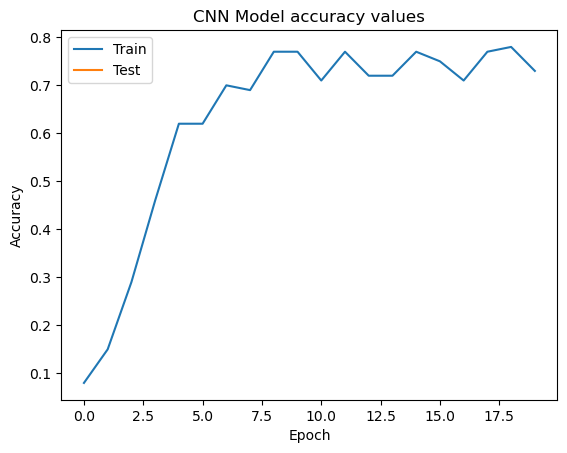

In [150]:
# Plot training & validation loss values
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history["val_accuracy"])
plt.title("CNN Model accuracy values")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

In [151]:
import cv2
import numpy as np

# Load the trained model from the .h5 file
model = load_model("vgg16model.h5")
#model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Read an input image (you can replace 'test.jpg' with your own image file)
for i in range(0, 5):
    img = cv2.imread(
        "/mnt/Storage Drive/Projects/E-YRC/EYRC_2023/Task 2/Task 2C/imgdir/cropped_image_"
        + str(i)
        + ".jpg"
    )
    img = cv2.resize(img, (IMAGE_SIZE))
    img = np.reshape(img, [1, IMAGE_SIZE[0],IMAGE_SIZE[1], 3])
    probabilities = model.predict(img)

    # Get the index of the class with the highest probability
    predicted_class_index = np.argmax(probabilities)
    print(f"Predicted class index: {predicted_class_index}")

    # If you have class labels, you can map the index to the actual class name
    class_labels = [
        "combat",
        "destroyedbuilding",
        "fire",
        "humanitarianaid",
        "militaryvehicles",
    ]
    predicted_class = class_labels[predicted_class_index]
    print(f"Predicted class: {predicted_class}")

    # fire, militaryvehicles, 

1/1 [==============================] - 0s 210ms/step
Predicted class index: 4
Predicted class: militaryvehicles
1/1 [==============================] - 0s 62ms/step
Predicted class index: 4
Predicted class: militaryvehicles
1/1 [==============================] - 0s 46ms/step
Predicted class index: 4
Predicted class: militaryvehicles
1/1 [==============================] - 0s 43ms/step
Predicted class index: 2
Predicted class: fire
1/1 [==============================] - 0s 30ms/step
Predicted class index: 2
Predicted class: fire


In [152]:
import pandas as pd
import pathlib

test_data = [
    "building1",
    "building2",
    "combat1",
    "combat2",
    "fire1",
    "fire2",
    "military1",
    "military2",
    "rehab1",
    "rehab2",
]

model = load_model("vgg16model.h5")
# model = load_model(
#     "/mnt/Storage Drive/Projects/E-YRC/EYRC_2023/Task 2/Task 2B/vgg16_transfer_learning_model.keras"
# )
root = pathlib.Path(
    "/mnt/Storage Drive/Projects/E-YRC/EYRC_2023/Task 2/Task 2C/Task2_dataset/training"
)
class_names = sorted([j.name.split("/")[-1] for j in root.iterdir()])


def prediction():
    headers = ["Acutal Image Name", "   Output Image Name"]
    data = []
    for i in test_data:
        img_path = (
            "/mnt/Storage Drive/Projects/E-YRC/EYRC_2023/Task 2/Task 2C/Task2_dataset/testing/"
            + i
            + ".jpeg"
        )
        image = cv2.imread(img_path)
        # input = Variable(image_tensor)
        # output = model.predict(image)
        img = cv2.resize(image, IMAGE_SIZE)
        img = np.reshape(img, [1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3])
        probabilities = model.predict(img)
        predicted_class_index = np.argmax(probabilities)
        print(f"Predicted class index: {predicted_class_index}")
        pred = class_names[predicted_class_index]
        data.append([i, pred])
    print(pd.DataFrame(data, columns=headers))


prediction()

1/1 [==============================] - 0s 150ms/step
Predicted class index: 1
1/1 [==============================] - 0s 30ms/step
Predicted class index: 4
1/1 [==============================] - 0s 30ms/step
Predicted class index: 4
1/1 [==============================] - 0s 28ms/step
Predicted class index: 4
1/1 [==============================] - 0s 45ms/step
Predicted class index: 4
1/1 [==============================] - 0s 48ms/step
Predicted class index: 2
1/1 [==============================] - 0s 46ms/step
Predicted class index: 4
1/1 [==============================] - 0s 45ms/step
Predicted class index: 4
1/1 [==============================] - 0s 50ms/step
Predicted class index: 4
1/1 [==============================] - 0s 28ms/step
Predicted class index: 2
  Acutal Image Name              Output Image Name
0         building1             DestroyedBuildings
1         building2  Military vehicles and weapons
2           combat1  Military vehicles and weapons
3           combat2  Mili

: 